In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.11.0


Gather Data

In [62]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

Copy of raw dataset to be set as the actual dataset for the notebook

In [63]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Dropping the rows that contain 0 values to keep the notebook simple

In [64]:
print("=====Before removing=====")
print(dataset.isna().sum())
dataset = dataset.dropna()
print("=====After removing=====")
print(dataset.isna().sum())

=====Before removing=====
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
=====After removing=====
MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


One Hot encode using map function of the pandas dataframe

In [65]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Splitting dataset into training and testing sets

In [66]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Plot data using seaborn

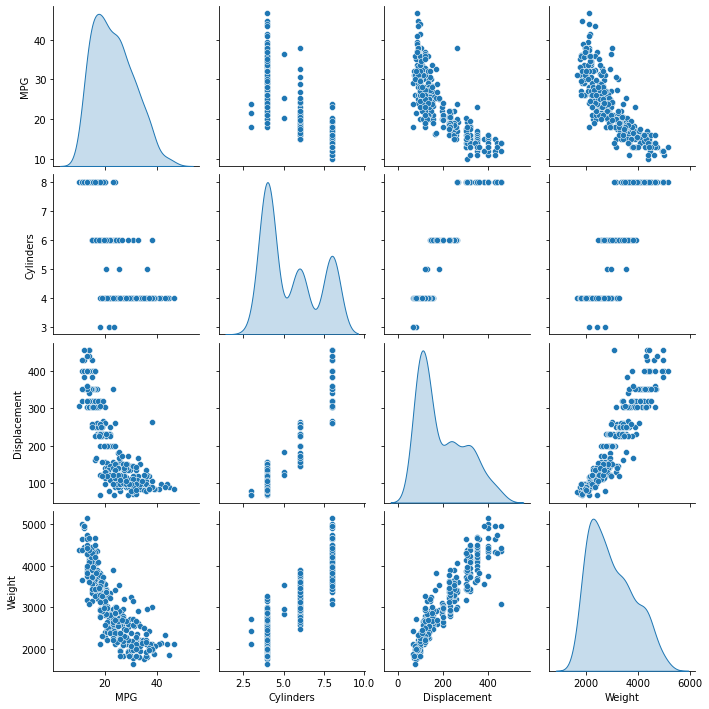

In [67]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [68]:
train_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.178344,0.197452,0.624204
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.383413,0.398712,0.485101
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


Removing the target variable (label) from the other variables (features)

In [69]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

Normalization Part using tensorflow normalization

In [70]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


Linear Regression Model, using only one Dense Layer

In [71]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

print(horsepower_model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_18 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________
None


Compiling and testing the one layer Dense Model (Essentially a linear model) with Adam Optimizer and Mean Aboslute Error as loss function

In [72]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging if 0.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


Epoch 1/100
8/8 [==============================] - 1s 53ms/step - loss: 22.8645 - val_loss: 22.9387
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 22.0612 - val_loss: 22.1385
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 21.2610 - val_loss: 21.3385
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 20.4620 - val_loss: 20.5388
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 19.6651 - val_loss: 19.7390
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 18.8605 - val_loss: 18.9389
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 18.0616 - val_loss: 18.1388
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 17.2618 - val_loss: 17.3388
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 16.4619 - val_loss: 16.5387
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 15.6683 - val_loss: 15.7425


        loss  val_loss  epoch
95  3.803931  4.202634     95
96  3.809870  4.214203     96
97  3.804670  4.183083     97
98  3.805686  4.165185     98
99  3.806341  4.178349     99


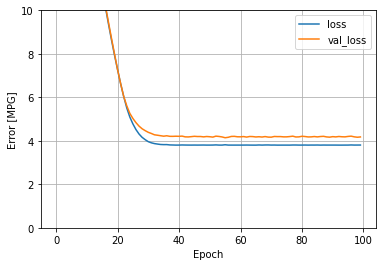

In [73]:
print(hist.tail())

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

test_results = {}
test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'],test_labels, verbose=0)

8/8 [==============================] - 0s 2ms/step


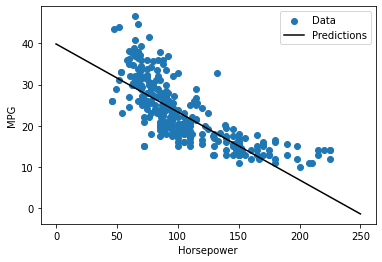

In [74]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x, y)

In [75]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_19 (Dense)            (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [76]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

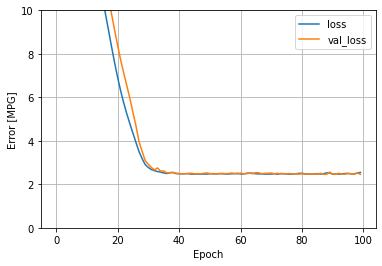

In [77]:
plot_loss(history)

In [78]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [79]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

dnn_horsepower_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_20 (Dense)            (None, 64)                128       
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [80]:
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 29ms/step - loss: 22.8729 - val_loss: 23.1949
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 22.5670 - val_loss: 22.8406
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 22.1961 - val_loss: 22.3804
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 21.7013 - val_loss: 21.7854
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 21.0684 - val_loss: 21.0169
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 20.2501 - val_loss: 20.0149
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 19.2040 - val_loss: 18.8304
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 18.0421 - val_loss: 17.5511
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 16.8121 - val_loss: 16.2968
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 15.3138 - val_loss: 15.0151
Epoch 11

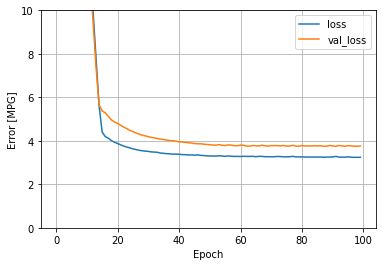

In [81]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

8/8 [==============================] - 0s 2ms/step


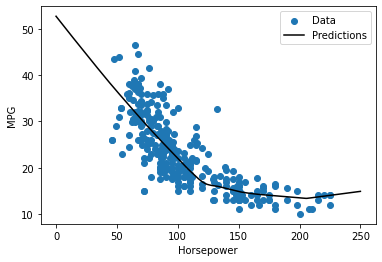

In [82]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plt.scatter(train_features['Horsepower'], train_labels, label='Data')
plt.plot(x, y, color='k', label='Predictions')
plt.xlabel('Horsepower')
plt.ylabel('MPG')   
plt.legend()


In [83]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [84]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_23 (Dense)            (None, 64)                640       
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [85]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 32ms/step - loss: 22.9590 - val_loss: 23.0828
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 22.2754 - val_loss: 22.3426
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 21.5208 - val_loss: 21.4613
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 20.5916 - val_loss: 20.3299
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 19.4000 - val_loss: 18.8544
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 17.8429 - val_loss: 17.0289
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 16.1292 - val_loss: 15.5205
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 14.4405 - val_loss: 14.0497
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 12.6507 - val_loss: 12.0373
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 10.5418 - val_loss: 9.2883
Epoch 

In [86]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [87]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.662414
linear_model,2.478077
dnn_horsepower_model,2.888817
dnn_model,1.785148


3/3 [==============================] - 0s 3ms/step


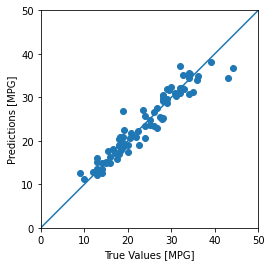

In [91]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [94]:
print(test_predictions)

[14.827 11.196 12.569 24.815 20.857 12.68  13.631 12.093 19.027 31.264
 23.734 26.815 15.134 25.33  13.61  14.867 15.121 13.53  18.72  12.935
 14.933 25.761 19.471 20.567 30.346 23.316 16.342 23.397 17.081 19.145
 28.659 20.364 18.631 20.85  26.544 15.829 19.15  32.005 29.658 17.518
 31.058 29.268 16.049 34.539 34.905 35.193 20.655 21.868 20.971 25.546
 30.967 17.297 31.772 18.195 17.582 17.876 32.118 34.449 22.495 24.932
 36.679 32.256 27.505 27.135 32.433 38.232 35.673 35.431 31.829 29.659
 22.366 22.938 30.357 30.757 33.958 35.005 37.256 30.549]


In [89]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


INFO:tensorflow:Assets written to: dnn_model\assets
